In [42]:
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot as plt
import itertools
from pmdarima import arima
from pmdarima import auto_arima
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
%config InlineBackend.figure_format = 'svg'


In [43]:
css_path = './temp.csv'
df = pd.read_csv(css_path, usecols=[0,1])

In [44]:
df.info()
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date Time    912 non-null    object
 1   Temperature  912 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 14.4+ KB
       Date Time  Temperature
0  2020/3/1 0:00           50
1  2020/3/1 0:30           50
2  2020/3/1 1:00           50
3  2020/3/1 1:30           50
4  2020/3/1 2:00           50


In [45]:
df['Date'] = pd.to_datetime(df['Date Time'])
df.index = df['Date']
df = df['Temperature']

In [46]:
for i in range(len(df)):
    df[i] = round(5 / 9 * (df[i] - 32))

In [47]:
df = df.resample('60T').mean()
df = df.fillna(df.bfill())

orin = df.copy()

df = df[:'2020-03-18 23:00:00']

df.head(1000)

Date
2020-03-01 00:00:00    10.0
2020-03-01 01:00:00    10.0
2020-03-01 02:00:00    10.0
2020-03-01 03:00:00    10.0
2020-03-01 04:00:00    10.0
                       ... 
2020-03-18 19:00:00    18.5
2020-03-18 20:00:00    17.5
2020-03-18 21:00:00    16.5
2020-03-18 22:00:00    16.0
2020-03-18 23:00:00    15.0
Freq: 60T, Name: Temperature, Length: 432, dtype: float64

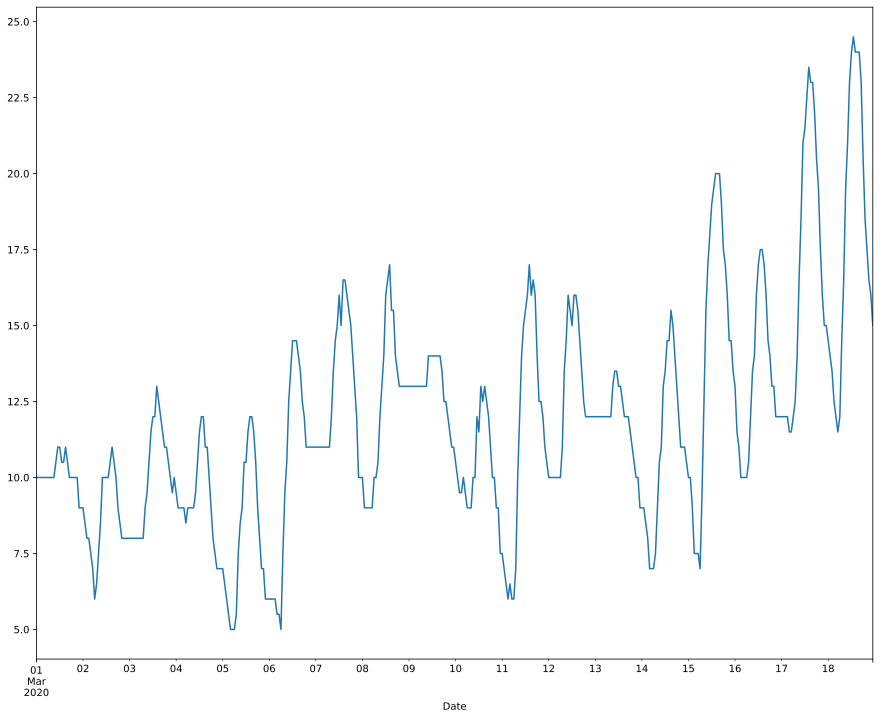

In [48]:
df.plot(figsize=(15, 12))
plt.show()

In [49]:
def test_stationarity(timeseries):
  dftest = adfuller(timeseries, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  return dfoutput['p-value']
 

In [50]:
test_stationarity(df)
# print(test_stationarity(df))
#If p-value is less than 0.05 data is stationary

0.9009526286977941

In [51]:
def stability_test(data):
    count = 0
    flag = True
    while test_stationarity(data) > 0.05:
        if count == 10:
            flag = False
            break
        count += 1
        data = data.diff(1)			# 差分
        data = data.fillna(data.bfill())	# 缺省值用后一值补充
    print('经过{}次差分，序列平稳'.format(count)) 
    return count, flag


经过1次差分，序列平稳


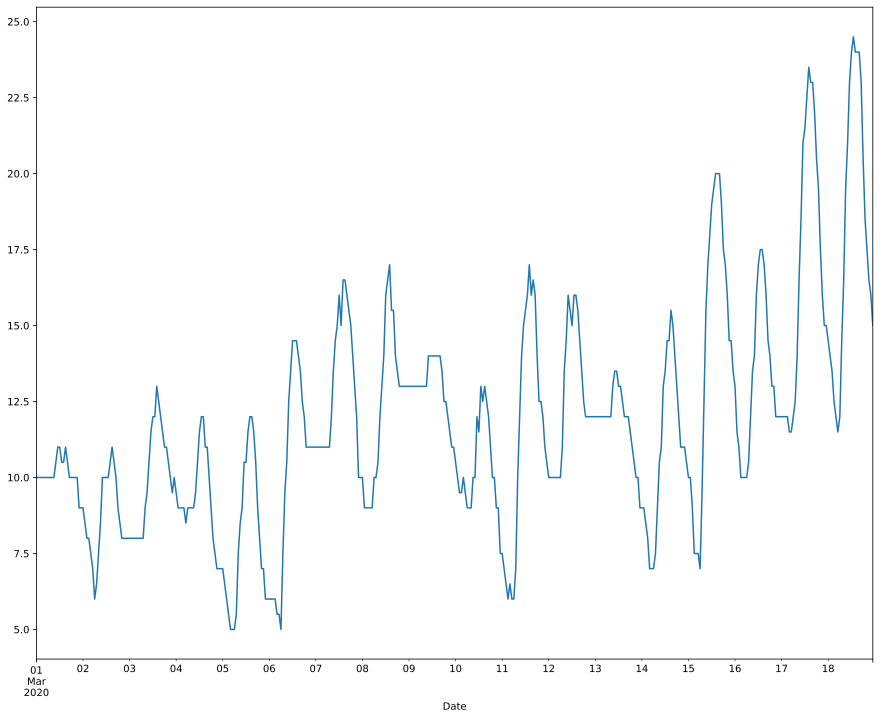

In [52]:
count, flag = stability_test(df)
if(flag):
    df.plot(figsize=(15, 12))
    plt.show()

In [53]:
def get_index(train_data):
    # Define the d and q parameters to take any value between 0 and 1
    q = d = range(0, 2)
    # Define the p parameters to take any value between 0 and 3
    p = range(0, 4)

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))
    
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    warnings.filterwarnings("ignore") # specify to ignore warning messages

    AIC = []
    SARIMAX_model = []
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(train_data,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()

                print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
                AIC.append(results.aic)
                SARIMAX_model.append([param, param_seasonal])
            except:
                continue
    print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))
    return SARIMAX_model[AIC.index(min(AIC))][0], SARIMAX_model[AIC.index(min(AIC))][1]

In [54]:
# order, sea_order = get_index(df)

In [55]:
def auto_parameters(data, s_num):
    
    kpss_diff = arima.ndiffs(data, alpha=0.05, test='kpss', max_d=s_num)
    adf_diff = arima.ndiffs(data, alpha=0.05, test='adf', max_d=s_num)
    d = max(kpss_diff, adf_diff)
    D = arima.nsdiffs(data, s_num)

    stepwise_model = auto_arima(data, start_p=0, start_q=0,
                                max_p=4, max_q=2, max_d=2, m=s_num,
                                seasonal=True, d=d, D=D, trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True)
    print("AIC: ", stepwise_model.aic())
    print(stepwise_model.order)		# (p,d,q)
    print(stepwise_model.seasonal_order)	# (P,D,Q,S)
    print(stepwise_model.summary())		# 详细模型
    return stepwise_model.order, stepwise_model.seasonal_order


In [56]:
# order, sea_order = auto_parameters(df, 24)
order = (2, 1, 1)
sea_order = (2, 0, 0, 24)


In [57]:
print(order, sea_order)


(2, 1, 1) (2, 0, 0, 24)


In [58]:
model=sm.tsa.statespace.SARIMAX(df,order=order,seasonal_order=sea_order)
results=model.fit()

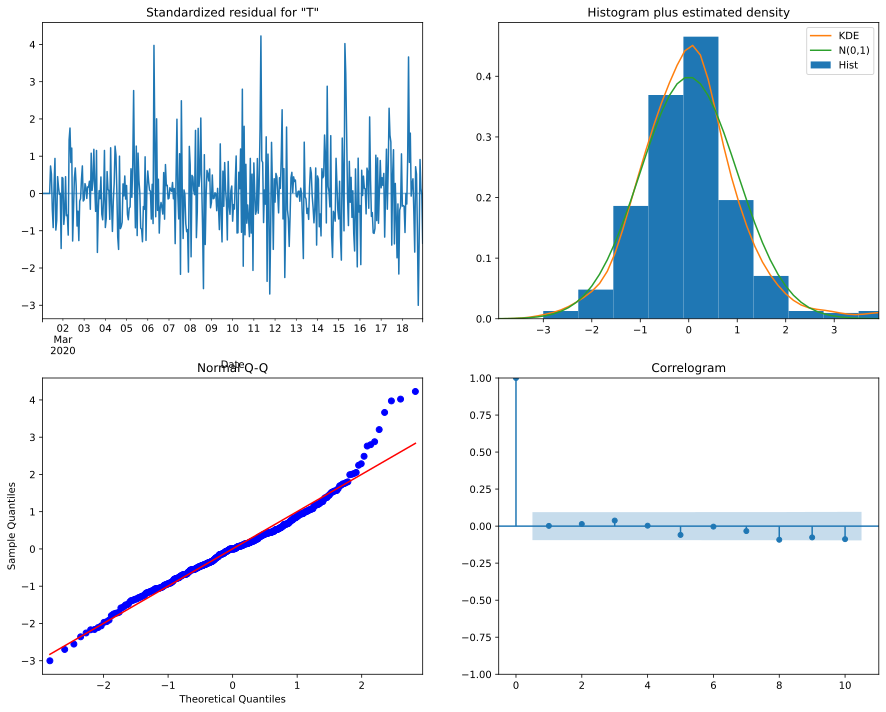

In [59]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [60]:
predict_ts = results.predict()
predict_ts_forecast = results.forecast(48)

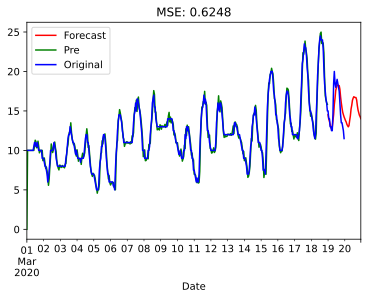

In [61]:
# text_size = 72
# predict_ts =  predict_ts[-text_size:]
# orin = orin[-text_size:]

predict_ts_forecast.plot(color='red', label='Forecast')
predict_ts.plot(color='green', label='Pre')
orin.plot(color='blue', label='Original')
plt.legend(loc='best')
plt.title('MSE: %.4f'% mean_squared_error(predict_ts,df[predict_ts.index]))
plt.show()